In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold


In [3]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [5]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## SVM (test)

In [5]:
celltype = 'B'
# subset data to celltype features
X = adata[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in adata.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced', max_iter=10000)
# OvR (one-vs-rest) decision function
# class_weight='balanced': Useful for imbalanced datasets, as it gives higher penalties to the minority class. Avoid bias toward the majority class
svm_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = svm_clf.predict(X_test)
# y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
metrics

[0.9994436373752048,
 0.9942321557317952,
 0.9992753623188406,
 0.996747379833755,
 0.9993673469587647,
 0.9935735157173534,
 0.9964469969617356]

## Stratified K-fold

In [6]:
import pickle

def SVM_strat_KFold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Fitting SVM model...')
    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced', max_iter=10000)
    # OvR (one-vs-rest) decision function
    # class_weight='balanced': Useful for imbalanced datasets, as it gives higher penalties to the minority class. Avoid bias toward the majority class
    svm_clf.fit(X_train, y_train)

    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score),
    'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_results = cross_validate(svm_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)
    # return cv_results

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_pr_auc'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return svm_clf, mean_metrics, cv_results




In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\SVM_model')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/SVM_model')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
cv_results_dict = {}
# likelihood_dict = {}
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics, cv_results = SVM_strat_KFold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Record CV results fold-by-fold
    cv_results_dict[celltype] = cv_results

    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output SVM model as pickle
    filename = f'SVM_{celltype}_linear_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

    # likelihood of the positive class for each observation
    # likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    # print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個
    # likelihood_dict[celltype] = likelihood


K-fold CV for: B
Fitting SVM model...
Cross validation...
[0.9994436326579104, 0.9948592375932745, 0.9986413043478262, 0.9967456160695443, 0.9990798833141843, 0.9936225447464967, 0.9964442147352252]
K-fold CV for: CD4_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.8383985344904878, 0.6513130561523275, 0.7810739225876484, 0.7097430260372345, 0.8194677138039163, 0.5657128429363557, 0.6044209730932588]
K-fold CV for: CD8_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.8653124989112243, 0.5469668018324189, 0.9527361963190183, 0.693196503448218, 0.9008561053775701, 0.5286402163746746, 0.6555760076853512]
K-fold CV for: DC
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9954176997167263, 0.832705372001238, 0.9930331767913951, 0.9058153635616177, 0.994252482184223, 0.827063621169426, 0.9071736807301694]
K-fold CV for: Mono
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9923576839627628, 0.9770106886570632, 0.9982656997444199, 0.9875236499148136, 0.9940276945908975, 0.9758421138432155, 0.9821347588038684]
K-fold CV for: NK
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9861913004267958, 0.9000002835493719, 0.9908915638227811, 0.943151737231571, 0.9882349153844864, 0.8928313724861793, 0.9367887159340075]
K-fold CV for: other
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.012665044330260156, 0.01264613621704668, 0.5903408678435902, 0.024761815361544186, 0.29522175397063927, 0.01756891981393905, -0.556162290325363]
K-fold CV for: other_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9299594321158402, 0.2963300997981198, 0.370094080214692, 0.3249377424009671, 0.6622893372520468, 0.1442071374504946, 0.29360615930651585]


In [8]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999444,0.994859,0.998641,0.996746,0.999080,0.993623,0.996444
CD4_T,0.838399,0.651313,0.781074,0.709743,0.819468,0.565713,0.604421
CD8_T,0.865312,0.546967,0.952736,0.693197,0.900856,0.528640,0.655576
DC,0.995418,0.832705,0.993033,0.905815,0.994252,0.827064,0.907174
Mono,0.992358,0.977011,0.998266,0.987524,0.994028,0.975842,0.982135
NK,0.986191,0.900000,0.990892,0.943152,0.988235,0.892831,0.936789
other,0.012665,0.012646,0.590341,0.024762,0.295222,0.017569,-0.556162
other_T,0.929959,0.296330,0.370094,0.324938,0.662289,0.144207,0.293606


In [10]:
all_metrics.to_csv('SVM_metrics_linear_l1.csv')

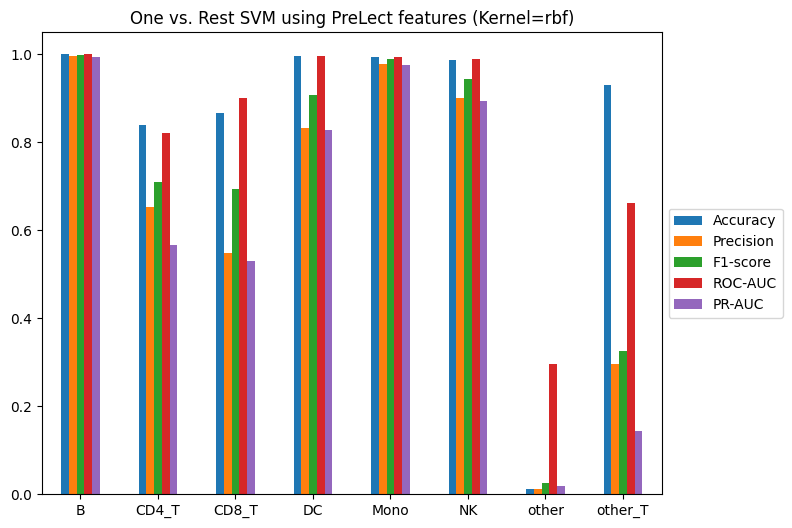

In [11]:
# Plot metrics for each celltype
cols = ['Accuracy', 'Precision', 'F1-score', 'ROC-AUC', 'PR-AUC']
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest SVM using PreLect features (Kernel=rbf)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
# turn likelihood_dict into dataframe
# likelihood_df = pd.DataFrame(likelihood_dict)
# likelihood_df.head()

In [12]:
# Recursive function to convert np.array to list
def convert_arrays_to_lists(data):
    if isinstance(data, dict):
        return {key: convert_arrays_to_lists(value) for key, value in data.items()}
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

# Convert all np.array elements in the dictionary to lists
dict_converted = convert_arrays_to_lists(cv_results_dict)
dict_converted

{'B': {'fit_time': [2.2084898948669434,
   2.0684566497802734,
   2.2415661811828613,
   2.265566110610962,
   2.2110509872436523],
  'score_time': [0.22618532180786133,
   0.22110867500305176,
   0.2366187572479248,
   0.24461889266967773,
   0.22062349319458008],
  'test_accuracy': [0.9994977398292315,
   0.9994590835329573,
   0.9995363573139634,
   0.9993818097519511,
   0.9993431728614481],
  'test_precision': [0.9959331224582015,
   0.9963800904977376,
   0.9954873646209387,
   0.9932493249324933,
   0.9932462854570013],
  'test_recall': [0.9981884057971014,
   0.9972826086956522,
   0.9990942028985508,
   0.9995471014492754,
   0.9990942028985508],
  'test_f1': [0.9970594888034382,
   0.9968311453146219,
   0.9972875226039785,
   0.9963882618510158,
   0.996161661774667],
  'test_roc_auc': [0.9989041289809161,
   0.998472342617658,
   0.9993358992865652,
   0.9994567474805724,
   0.9992302982052101],
  'test_pr_auc': [0.9942834373780873,
   0.9939043572470121,
   0.9946629288325

In [13]:
import json
with open('SVM_KFold_linear_l1.json', 'w') as f:
    json.dump(dict_converted, f)

## Evaluate by DEGn

In [ ]:
count_df

In [7]:
# Read DEG table
# os.chdir("/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table")
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\L1_DEG\L1_DEG_table")
os.chdir(home_path / 'Source_code_supplementary/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table')

# celltype = 'B'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
# n_features = count_df.loc[celltype, 'Feature_count']  # 3902
# DEGn = DEG_table['names'][:n_features].tolist()

In [9]:
def SVM_classifier_DEG(data, DEGn, celltype):
    # subset data to celltype features
    X = data[:, DEGn].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced')
    svm_clf.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = svm_clf.predict(X_test)
    # y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
    return svm_clf, metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist() 
    clf, celltype_metrics = SVM_classifier_DEG(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics